In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Define the Mishra's Bird function

In [179]:
# constrains are imposed by returning a very big value if the argument is out of the constrain area

def my_bird(x):
    if (x[0] + 5) ** 2 + (x[1] + 5) ** 2 < 25:
        return sin(x[1]) * exp((1 - cos(x[0])) ** 2) + cos(x[0]) * exp((1 - sin(x[1])) ** 2) + (x[0] - x[1]) ** 2
    else:
        return 100000000

bird = np.vectorize(my_bird, signature='(2)->()')

In [182]:
# unconstrained version for the purpose of plotting

def my_bird_unconstrained(x):
    return sin(x[1]) * exp((1 - cos(x[0])) ** 2) + cos(x[0]) * exp((1 - sin(x[1])) ** 2) + (x[0] - x[1]) ** 2

bird_unconstrained = np.vectorize(my_bird_unconstrained, signature='(2)->()')

In [185]:
X = np.arange(-10, 10, 0.1)
Y = np.arange(-10, 10, 0.1)
X, Y = np.meshgrid(X, Y)

In [186]:
Z = bird_unconstrained(np.stack((X, Y), axis=-1))

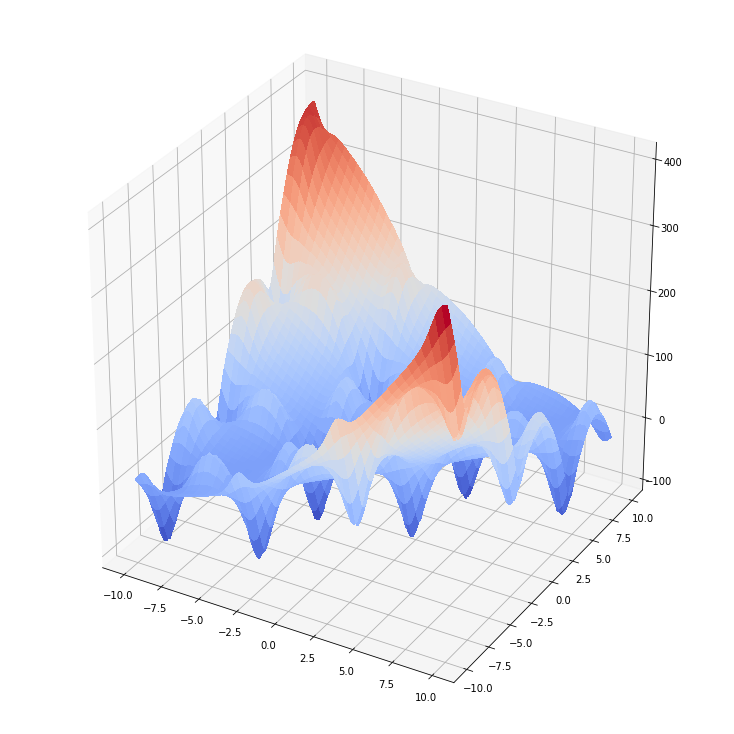

In [188]:
from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

### Utility Simplex class

In [195]:
class Simplex:
    def __init__(self, a, b, c):
        self.best = a
        self.worst = b
        self.middle = c
        self.reflected = None
        self.rearrange()
    
    def rearrange(self):
        vertices = np.array([self.best, self.middle, self.worst])
        vals = bird(vertices)
        indices = vals.argsort()
        vertices = vertices[indices]
        self.best = vertices[0]
        self.worst = vertices[2]
        self.middle = vertices[1]
        self.center = (self.best + self.middle) / 2
    
    def reflect(self, alpha):
        xr = self.center + alpha * (self.center - self.worst)
        self.reflected = xr
        
        return xr, bird(xr)
    
    def expand(self, gamma):
        xe = self.center + gamma * (self.reflected - self.center)
        
        return xe, bird(xe)
        
    def contract(self, rho):
        xc = self.center + rho * (self.worst - self.center)
        
        return xc, bird(xc)
    
    def shrink(self, sigma):
        self.worst = self.best + sigma *(self.worst - self.best)
        self.middle = self.best + sigma * (self.middle - self.best)
        
    def check_std(self):
        vertices = np.array([self.best, self.middle, self.worst])
        vals = bird(vertices)
        
        return np.std(vals)

### Implemeting the Nelder-Mead algorithm

In [111]:
def nelder_mead(a, b, c, alpha=1, gamma=2, rho=0.5, sigma=0.5, tol=1e-6):
    s = Simplex(a, b, c)
    triangles_to_plot = []
    while True:
        triangles_to_plot.append([s.best, s.worst, s.middle])
        s.rearrange()
        bval = bird(s.best)
        mval = bird(s.middle)
        wval = bird(s.worst)
        
        if s.check_std() <= tol:    # terminating if the function values don't differ too much
            return bval, s.best, np.array(triangles_to_plot)
        
        xr, xrval = s.reflect(alpha)
        if bval <= xrval and xrval < mval:
            s.worst = xr
        elif bval > xrval:
            xe, xeval = s.expand(gamma)
            if xeval < xrval:
                s.worst = xe
            else:
                s.worst = xr
        else:
            xc, xcval = s.contract(rho)
            if xcval < wval:
                s.worst = xc
            else:
                s.shrink(sigma)

### Checking if it works

In [193]:
bird([-3.1302468, -1.5821422])    # global minimum from Wikipedia

array(-106.76453675)

In [196]:
minval, xstar, triangles = nelder_mead([-2, -2], [-3, -3], [-1, -3], tol=1e-6)
minval, xstar

(array(-106.76453629), array([-3.13023709, -1.58219896]))

Yep, it works.

### Plotting the simplices

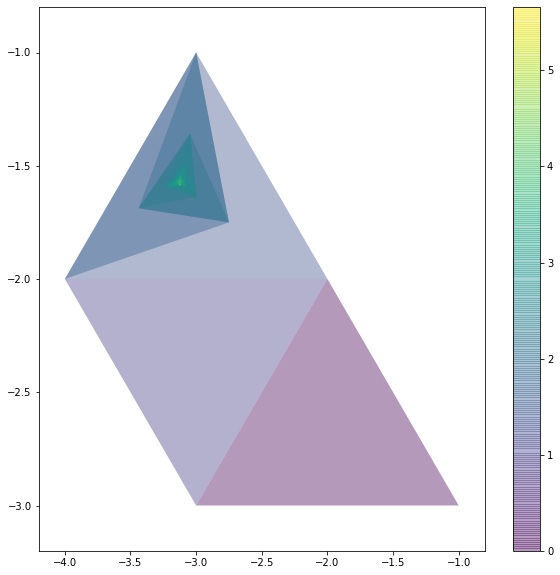

In [165]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots(figsize=(10, 10))
patches = []
for triangle in triangles:
    patches.append(Polygon(triangle, True))
xmin, xmax = np.min(triangles[:, :, 0]) - 0.2, np.max(triangles[:, :, 0]) + 0.2
ymin, ymax = np.min(triangles[:, :, 1]) - 0.2, np.max(triangles[:, :, 1]) + 0.2
colors = np.sqrt(np.arange(len(patches)))
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)
plt.xlim((xmin, xmax))
plt.ylim((ymin, ymax))
fig.colorbar(p, ax=ax)
plt.show()

### Convergence to a different minimum

In [212]:
# initial guess
minval, xstar, triangles = nelder_mead([-2, -2], [-3, -3], [-1, -3], tol=1e-6)
minval, xstar

(array(-106.76453629), array([-3.13023709, -1.58219896]))

In [208]:
# different starting point
minval, xstar, _ = nelder_mead([-8.3, -1.1], [-7, -3], [-8.1, -1.9], tol=1e-6) 
minval, xstar

(array(-87.31088149), array([-3.17563439, -7.81982287]))

Yep, different minimum.

In [210]:
# different parameters
minval, xstar, triangles = nelder_mead([-2, -2], [-3, -3], [-1, -3], alpha=3, gamma=3, rho=0.1, sigma=0.4, tol=1e-6)
minval, xstar

(array(-23.24782253), array([-2.06829831, -2.09296666]))

Yep, different minimum